# Corporate Sustainability

## 0 - Imports and Dependencies

### Dependencies

To run this notebook, please make sure you have the following packages installed:

- `pandas`: For handling data in dataframes.
- `datasets`: For loading datasets.
- `spacy`: For natural language processing.
- `scikit-learn`: For machine learning algorithms, vectorization, model evaluation, and pipelines.
- `wordcloud`: For creating a visual interpretation of text analytics.

You can install these packages using the following command:

```bash
pip install pandas datasets spacy scikit-learn wordcloud


python -m spacy download en_core_web_sm


In [1]:
# General imports
import pandas as pd
import numpy as np
import spacy
from textblob import TextBlob
import plotly.express as px
import seaborn as sns
from collections import Counter
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## 1 - Data Loading

In [2]:
# Load data
dataset = load_dataset('climatebert/environmental_claims')

Found cached dataset parquet (/Users/rita/.cache/huggingface/datasets/climatebert___parquet/climatebert--environmental_claims-3af61fabe0b07b9a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Display to show how the format of the dataset looks like
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 300
    })
})

In [4]:
# Creating a dataframe for each split

env_claim_train = pd.DataFrame(dataset['train'])
env_claim_test = pd.DataFrame(dataset['test'])
env_claim_val = pd.DataFrame(dataset['validation'])


In [5]:
# Define color codes
class Colors:
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    ENDC = '\033[0m'

# Displaying the characteristics of the data
print(Colors.OKGREEN + "Training data" + Colors.ENDC)
print(f"The shape of the training data is: {env_claim_train.shape}")
display(env_claim_train.head())
display(env_claim_train.describe())

print(Colors.OKBLUE + "\nTest data" + Colors.ENDC)
print(f"The shape of the test data is: {env_claim_test.shape}")
display(env_claim_test.head())
display(env_claim_test.describe())

print(Colors.OKCYAN + "\nValidation data" + Colors.ENDC)
print(f"The shape of the validation data is: {env_claim_val.shape}")
display(env_claim_val.head())
display(env_claim_val.describe())

Training data
The shape of the training data is: (2400, 2)


,text,label
0,It will enable E.ON to acquire and leverage a ...,0
1,And that's honestly most markets in the U.S. S...,0
2,A key pillar of our strategy is to continue to...,0
3,The goal to reduce relative GHG emissions by 2...,1
4,"As you know, we drove about $75 million of cos...",0


,label
count,2400.000000
mean,0.225833
std,0.418217
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Test data
The shape of the test data is: (300, 2)


,text,label
0,I don't know what the economic bumps are going...,0
1,2 oven that will almost deliver as good as a p...,0
2,"And so certainly, we have a lot of cost saving...",0
3,So it's only in back half as we continue our e...,0
4,We have worked hard to make real energy effici...,0


,label
count,300.000000
mean,0.213333
std,0.410346
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Validation data
The shape of the validation data is: (300, 2)


,text,label
0,The method used for these impairment tests is ...,0
1,We're making the transition from strictly gas ...,0
2,"At the same time, desks are being equipped wit...",1
3,In addition to the goal of having net zero emi...,1
4,The exchange rates used for the consolidated i...,0


,label
count,300.000000
mean,0.213333
std,0.410346
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## 2- EDA

In [6]:
# Concatenate sets 
claim_dataset = pd.concat([env_claim_train, env_claim_test, env_claim_val], ignore_index = True)
print("Number of claims in the dataset:", claim_dataset.shape[0])    # observations
print("Number of variables in the dataset:", claim_dataset.shape[1]) # variables 

Number of claims in the dataset: 3000
Number of variables in the dataset: 2


In [7]:
# NaNs 
print("Number of NaNs:")
display(claim_dataset.isna().sum())

# Duplicates
print("Number of duplicates:")
display(claim_dataset.duplicated().sum())

# Variable types
print("Variable types:")
claim_dataset.dtypes

Number of NaNs:


text     0
label    0
dtype: int64

Number of duplicates:


0

Variable types:


text     object
label     int64
dtype: object

### Word Count by Claim

The average number of words in each claim is equal to: 24.0 words.


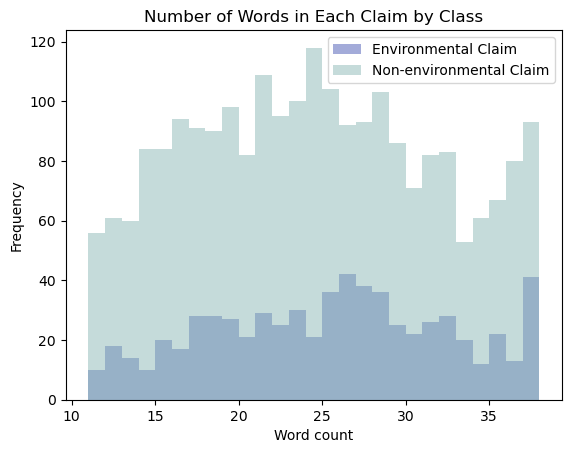

In [8]:
# Word count
claim_dataset["word count"] = claim_dataset["text"].apply(lambda x: len(x.split()))
print("The average number of words in each claim is equal to:", round(claim_dataset["word count"].mean(),0), "words.")

# Graphical representation by class
class_1_counts = claim_dataset[claim_dataset["label"] == 1]["word count"]
class_2_counts = claim_dataset[claim_dataset["label"] == 0]["word count"]

plt.hist(class_1_counts, bins = range(11, 39), alpha = 0.5, label = "Environmental Claim", color = "#4958B5")
plt.hist(class_2_counts, bins = range(11, 39), alpha = 0.5, label = "Non-environmental Claim", color = "#8DB8B7")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.title("Number of Words in Each Claim by Class")
plt.legend(loc = "upper right")
plt.show()

### Claim Cleaning

In [9]:
# Load English language model
sp = spacy.load('en_core_web_sm')

# Apply the Spacy sp function to each row of the 'text' column
claim_dataset["spacy object"] = claim_dataset["text"].apply(sp)

# Filter stopwords, punctuation and spaces
def filter_tokens(token):
    return not token.is_stop and not token.is_punct and not token.is_space

# Remove stopwords, punctuation, and whitespace from each Spacy object
claim_dataset["filtered tokens"] = claim_dataset["spacy object"].apply(lambda doc: [token.text for token in doc if filter_tokens(token)])

print("This is the first sentence before filtering:", claim_dataset.iloc[0,0])
print("\nThis is the first sentence after filtering:", claim_dataset.iloc[0,4])

# Calculating new average value of words per claim
number_words = [len(x) for x in claim_dataset["filtered tokens"]]
print("\nThe average number of words per claim is now:", round(np.mean(number_words),0))

This is the first sentence before filtering: It will enable E.ON to acquire and leverage a comprehensive understanding of the transfor- mation of the energy system and the interplay between the individual submarkets in regional and local energy supply sys- tems.

This is the first sentence after filtering: ['enable', 'E.ON', 'acquire', 'leverage', 'comprehensive', 'understanding', 'transfor-', 'mation', 'energy', 'system', 'interplay', 'individual', 'submarkets', 'regional', 'local', 'energy', 'supply', 'sys-', 'tems']

The average number of words per claim is now: 13.0


### Environmental Claims versus Non-Environmental Claims

In [10]:
# Mean 
print("Average number of words per claim by class:")
display(claim_dataset.groupby("label").mean().round())

# Median
print("\nMedian number of words per claim by class:")
display(claim_dataset.groupby("label").median())

Average number of words per claim by class:


,word count
label,
0,24.0
1,25.0



Median number of words per claim by class:


,word count
label,
0,24.0
1,26.0


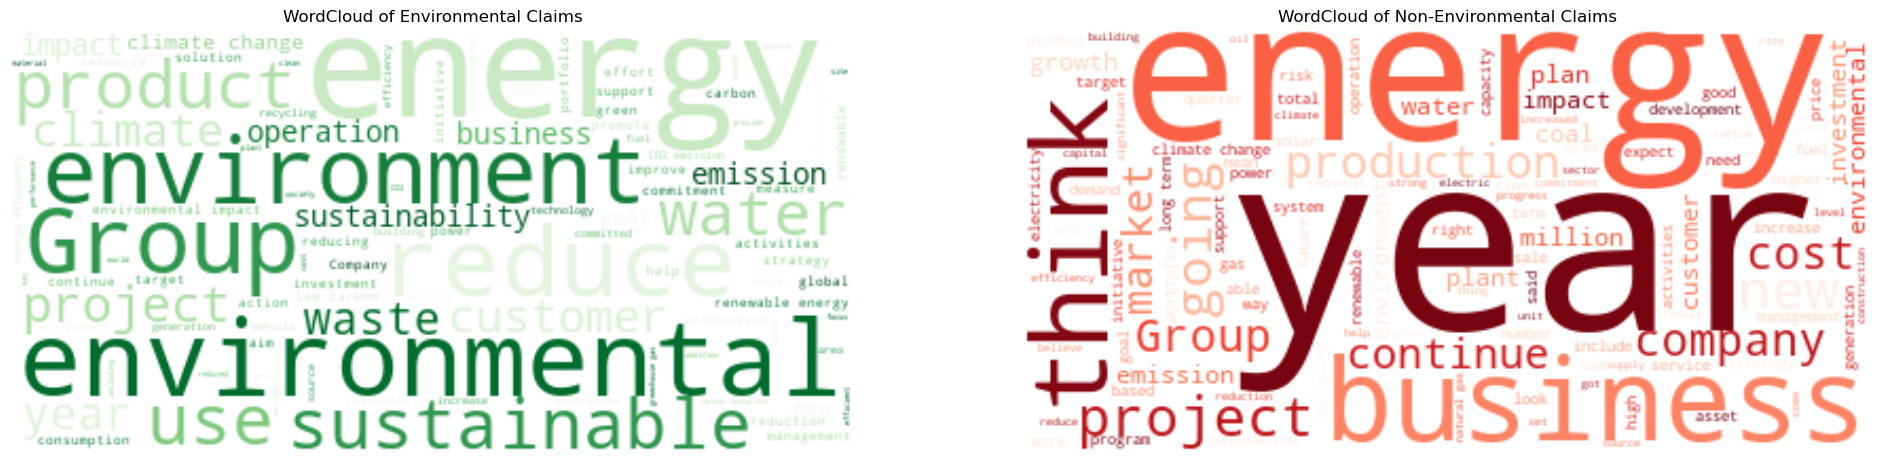

In [11]:
# WordCloud hue by class label

# Join the strings in each list into a single string
claim_dataset["joined tokens"] = claim_dataset["filtered tokens"].apply(lambda tokens: ' '.join(tokens))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

# For Environmental Claims
text = " ".join(word for word in claim_dataset[claim_dataset["label"]==1]["joined tokens"])
wordcloud = WordCloud( background_color = "white", colormap = "Greens").generate(text)

ax1.imshow(wordcloud, interpolation = "bilinear")
ax1.set(title = "WordCloud of Environmental Claims")
ax1.axis("off")

# For Non-Environmental Claims
text = " ".join(word for word in claim_dataset[claim_dataset["label"]==0]["joined tokens"])
wordcloud = WordCloud(background_color = "white", colormap = "Reds").generate(text)

ax2.imshow(wordcloud, interpolation='bilinear')
ax2.set(title = "WordCloud of Non-Environmental Claims")
ax2.axis("off")
plt.show()

In [12]:
# Most frequent words for environmental claims
top = Counter([item for sublist in claim_dataset["joined tokens"][claim_dataset["label"]==1] for item in str(sublist).split()])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ["Common Words", "Count"]
print("Most frequent words for environmental claims:")
display(temp.style.background_gradient(cmap = "Greens"))

# Most frequent words for non-environmental claims
top = Counter([item for sublist in claim_dataset["joined tokens"][claim_dataset["label"]==0] for item in str(sublist).split()])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ["Common Words", "Count"]
print("\nMost frequent words for non-environmental claims:")
display(temp.style.background_gradient(cmap = "Reds"))

Most frequent words for environmental claims:


,Common Words,Count
0,energy,181
1,environmental,145
2,carbon,109
3,emissions,105
4,reduce,81
5,renewable,63
6,impact,62
7,climate,61
8,sustainable,54
9,power,54



Most frequent words for non-environmental claims:


,Common Words,Count
0,energy,258
1,year,236
2,emissions,150
3,business,148
4,going,133
5,gas,132
6,million,131
7,think,130
8,new,117
9,cost,116


### Studying Energy Claims using N-Grams

In [ ]:
# Still need to finish this 

In [30]:
# Subsample of claims with word "energy" inside
energy_df = claim_dataset[claim_dataset["joined tokens"].str.contains("energy")]
print("In the original dataset, there are", len(energy_df), "claims containing the word 'energy'.")

# Subsample of claims with word "energy" inside and label == 1
energy_df_1 = energy_df[energy_df["label"] == 1]

# Subsample of claims with word "energy" inside and label == 0
energy_df_0 = energy_df[energy_df["label"] == 0]

In the original dataset, there are 370 claims containing the word 'energy'.


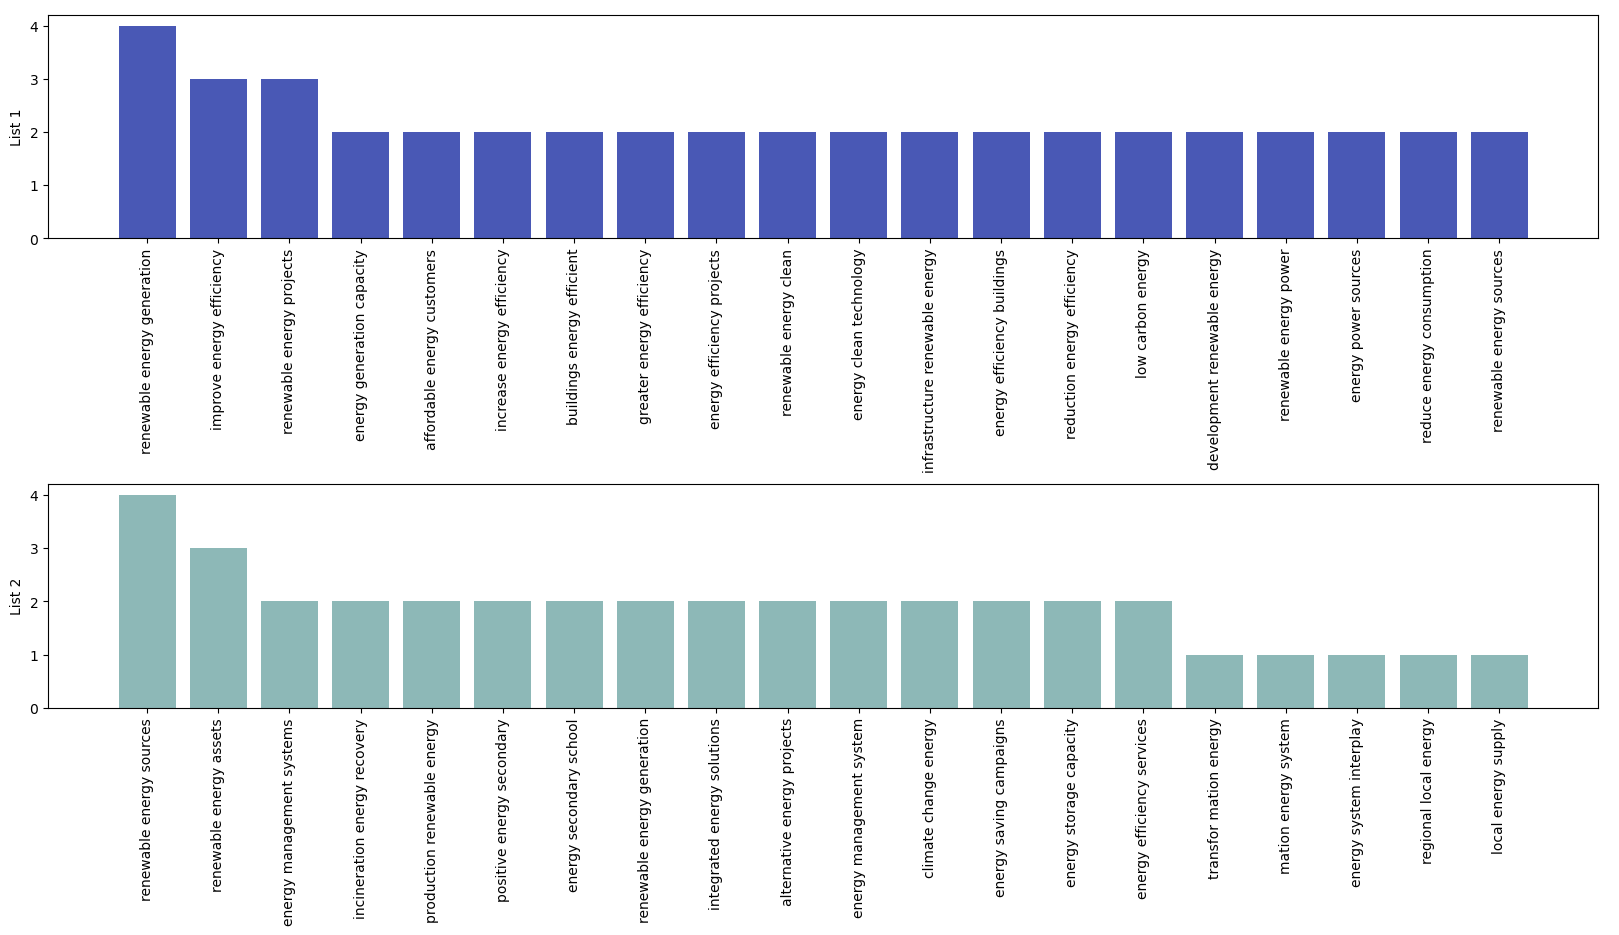

In [89]:
# Function calculating most frequent N-Grams given corpus, n-grams

def top_n_ngram(energy_corpus, ngram = 3):
    vec = CountVectorizer(ngram_range = (ngram,ngram)).fit(energy_corpus)
    words_bag = vec.transform(energy_corpus)  # Have the count of  all the words for each claim
    sum_words = words_bag.sum(axis = 0)       # Calculates the count of all the word in the whole claim
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse = True)
    return words_freq

# Call function on both datasets 
pop_words_1 = top_n_ngram(energy_df_1["joined tokens"], 3)  
pop_words_0 = top_n_ngram(energy_df_0["joined tokens"], 3)  

# Select top 20 N-Grams having 'energy' in text 
pop_energy_1 = [t for t in pop_words_1 if "energy" in t[0]]
pop_energy_1 = pop_energy_1[:20]
pop_energy_0 = [t for t in pop_words_0 if "energy" in t[0]]
pop_energy_0 = pop_energy_0[:20]

# Graphical representation

# Extract x and y values from each list
x1, y1 = zip(*pop_energy_1)
x2, y2 = zip(*pop_energy_0)

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (20,9))
fig.subplots_adjust(hspace = 1.1)


# Create the first bar plot on ax1
ax1.bar(x1, y1, color = "#4958B5")
ax1.set_ylabel("Top 20 3-grams ")
ax1.set_xticks(range(len(x1)))
ax1.set_xticklabels(x1, rotation=90)


# Create the second bar plot on ax2
ax2.bar(x2, y2, color="#8DB8B7")
ax2.set_ylabel('List 2')
ax2.set_xticks(range(len(x2)))
ax2.set_xticklabels(x2, rotation=90)


# Add x-axis label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.xlabel('3-Grams')

# Show the plot
plt.show()

"20 Most Frequent 3-grams Containing Word 'Energy'"

In [28]:
[t for t in pop_words if "energy efficiency projects" in t[0]]

[('energy efficiency projects', 3)]

In [29]:
len([t for t in claim_dataset["joined tokens"] if 'renewable energy sources' in t])

4

### Declaring the train and test datasets for X and y

In [ ]:
X_train, y_train = env_claim_train['text'], env_claim_train['label']
X_test, y_test = env_claim_test['text'], env_claim_test['label']
X_val, y_val = env_claim_val['text'], env_claim_test['label']

### Exploring Labelled Data and Defining Base Rate

In [ ]:
# Train Set
print(Colors.OKGREEN + "Train set per class:" + Colors.ENDC)
display(y_train.value_counts())
      

# Test Set 
print(Colors.OKBLUE + "\nTest set per class:" + Colors.ENDC)
display(y_test.value_counts())

# Validation Set
print(Colors.OKCYAN + "\nValidation set per class:" + Colors.ENDC)
display(y_val.value_counts())


# Graphical representation
outcome_variable = pd.concat([y_train, y_test, y_val])
outcome_variable.value_counts().plot.bar(color = ["#4958B5", "#8DB8B7"], grid = False)
plt.ylabel("Number of observations")
plt.xlabel("Class")
plt.title("Number of Observations per Class")
plt.xticks(rotation = 0)
plt.show()

In [ ]:
# Base rate
base_rate = round(len(outcome_variable[outcome_variable == 0]) / len (outcome_variable), 4)
print(f'The base rate is: {base_rate*100:0.2f}%')

### Balancing Labelled Data

In [ ]:
# Get indices of "0" outcomes in the training set
train_zeros_idx = pd.Series(y_train[y_train == 0].index)

# Randomly select a balanced number of "0" outcomes
train_zeros_sample_idx = train_zeros_idx.sample(n = sum(y_train == 1), random_state = 7)

# Use the sampled indices to get the final balanced training set
X_train_bal = pd.concat([X_train[y_train == 1], X_train[train_zeros_sample_idx]])
y_train_bal = pd.concat([y_train[y_train == 1], y_train[train_zeros_sample_idx]])


# Get indices of "0" outcomes in the test set
test_zeros_idx = pd.Series(y_test[y_test == 0].index)

# Randomly select a balanced number of "0" outcomes
test_zeros_sample_idx = test_zeros_idx.sample(n = sum(y_test == 1), random_state = 7)

# Use the sampled indices to get the final balanced test set
X_test_bal = pd.concat([X_test[y_test == 1], X_test[test_zeros_sample_idx]])
y_test_bal = pd.concat([y_test[y_test == 1], y_test[test_zeros_sample_idx]])

# Get indices of "0" outcomes in the validation set
val_zeros_idx = pd.Series(y_val[y_val == 0].index)

# Randomly select a balanced number of "0" outcomes
val_zeros_sample_idx = val_zeros_idx.sample(n = sum(y_val == 1), random_state = 7)

# Use the sampled indices to get the final balanced validation set
X_val_bal = pd.concat([X_val[y_val == 1], X_val[val_zeros_sample_idx]])
y_val_bal = pd.concat([y_val[y_val == 1], y_val[val_zeros_sample_idx]])

In [ ]:
print("Number of observations per class after balancing the classes:\n")

# Train Set
print(Colors.OKGREEN + "Train set per class" + Colors.ENDC)
display(y_train_bal.value_counts())
      

# Test Set 
print(Colors.OKBLUE + "\nTest set per class" + Colors.ENDC)
display(y_test_bal.value_counts())

# Validation Set
print(Colors.OKCYAN + "\nValidation set per class" + Colors.ENDC)
display(y_val_bal.value_counts())

print("\nThe new balanced dataset contains", len(y_train_bal + y_test_bal + y_val_bal) , "observations.")

## 3- 

### Text Classification using TF-IDF Vectorization and Logistic Regression

In [ ]:
# Create a spaCy tokenizer
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def spacy_tokenizer(text):
    return [tok.lemma_.lower().strip() for tok in nlp(text) if tok.is_alpha and not tok.is_stop]

# Create a TfidfVectorizer with the spaCy tokenizer
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1, 2), max_df=0.85, min_df=2)

# Create a logistic regression classifier
clf = LogisticRegression(solver='liblinear')

# Create a pipeline with the vectorizer and classifier
pipe = Pipeline([('vectorizer', vectorizer), ('classifier', clf)])

# Train the model
pipe.fit(X_train, y_train)

# Test the model
y_pred = pipe.predict(X_test)

# Calculate accuracy and print the classification report
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

### Visualizing Word Importance with Word Clouds for Each Class

In [ ]:
def plot_word_cloud(classifier, vectorizer, class_index, class_label):
    # Get the feature names (words) from the vectorizer
    words = vectorizer.get_feature_names_out()

    # Get the coefficients (importance) of the words for the given class
    word_importance = classifier.coef_[0]

    # Create a dictionary with the words and their importance
    if class_index == 0:
        colormap = "Reds"
        word_importance_dict = {words[i]: -word_importance[i] for i in range(len(words)) if word_importance[i] < 0}
    else:
        word_importance_dict = {words[i]: word_importance[i] for i in range(len(words)) if word_importance[i] > 0}
        colormap = "Greens"

    # Create a WordCloud object
    wc = WordCloud(width=800, height=400, background_color="white", colormap=colormap)

    # Generate the word cloud using the word importance dictionary
    wc.generate_from_frequencies(word_importance_dict)

    # Plot the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {class_label}", fontsize=20)
    plt.show()

# Create the word clouds for each class
plot_word_cloud(clf, vectorizer, 0, "Greenwashing Companies")
plot_word_cloud(clf, vectorizer, 1, "Genuine Green impact Companies")


## Environment description

In [ ]:
%load_ext watermark
%watermark -v -p pandas,numpy,sklearn,datasets,spacy,wordcloud